# Capstone 2: Exploratory Data Analysis

## Objectives

### From Rubric:
* Every feature is investigated using either histograms, bi-plots, or other visual and numeric means.
* Pearson correlation coefficients and other statistical methods were used to identify statistical relationship strengths.

### From Mentor: 
* Distribution and descriptive statistics for each feature (histograms and summary)
* Correlation between target feature and each explanatory feature. And some visualization.
    * Continuous vs continuous: scatter plot, calculate correlation, and p value (sig or not)
    * Continuous and categorical
        * t test when there is only 2 categories
        * Annova or regression for multiple categories (log regression?)
    * Categorical vs categorical: kai square
* This is all for normal distribution - there are other tests for data that is not normally distributed (ie Shapiro test )

In [39]:
# import packages
import numpy as np 
import pandas as pd 
import matplotlib.pyplot as plt 
import seaborn as sns
from scipy import stats

In [3]:
# import data
wildfires = pd.read_csv('Datasets/wildfires_withvars.csv', index_col='OBJECTID', low_memory=False)
wildfires.head()

,Unnamed: 0,FOD_ID,FPA_ID,SOURCE_SYSTEM_TYPE,SOURCE_SYSTEM,NWCG_REPORTING_AGENCY,NWCG_REPORTING_UNIT_ID,NWCG_REPORTING_UNIT_NAME,SOURCE_REPORTING_UNIT,SOURCE_REPORTING_UNIT_NAME,...,NA_L2NAME,NA_L1CODE,NA_L1NAME,L3_KEY,L2_KEY,L1_KEY,Shape_Leng,Shape_Area,geometry,COUNTY_NAME
OBJECTID,,,,,,,,,,,,,,,,,,,,,
1,0,1,FS-1418826,FED,FS-FIRESTAT,FS,USCAPNF,Plumas National Forest,0511,Plumas National Forest,...,WESTERN CORDILLERA,6,NORTHWESTERN FORESTED MOUNTAINS,5 Sierra Nevada,6.2 WESTERN CORDILLERA,6 NORTHWESTERN FORESTED MOUNTAINS,2.701704e+06,5.310270e+10,POINT (-121.00583333 40.03694444),Plumas
8,1,8,FS-1418854,FED,FS-FIRESTAT,FS,USCASHF,Shasta-Trinity National Forest,0514,Shasta-Trinity National Forest,...,WESTERN CORDILLERA,6,NORTHWESTERN FORESTED MOUNTAINS,78 Klamath Mountains/California High North Co...,6.2 WESTERN CORDILLERA,6 NORTHWESTERN FORESTED MOUNTAINS,2.146616e+06,4.835824e+10,POINT (-122.43388889 40.96805556),Shasta
9,2,9,FS-1418856,FED,FS-FIRESTAT,FS,USCASHF,Shasta-Trinity National Forest,0514,Shasta-Trinity National Forest,...,WESTERN CORDILLERA,6,NORTHWESTERN FORESTED MOUNTAINS,78 Klamath Mountains/California High North Co...,6.2 WESTERN CORDILLERA,6 NORTHWESTERN FORESTED MOUNTAINS,2.146616e+06,4.835824e+10,POINT (-122.28333333 41.23361111),Siskiyou
77,3,78,FS-1419054,FED,FS-FIRESTAT,FS,USCASRF,Six Rivers National Forest,0510,Six Rivers National Forest,...,WESTERN CORDILLERA,6,NORTHWESTERN FORESTED MOUNTAINS,78 Klamath Mountains/California High North Co...,6.2 WESTERN CORDILLERA,6 NORTHWESTERN FORESTED MOUNTAINS,2.146616e+06,4.835824e+10,POINT (-123.53305556 41.03722222),Humboldt
88,4,89,FS-1419071,FED,FS-FIRESTAT,FS,USCAANF,Angeles National Forest,0501,Angeles National Forest,...,MEDITERRANEAN CALIFORNIA,11,MEDITERRANEAN CALIFORNIA,8 Southern California Mountains,11.1 MEDITERRANEAN CALIFORNIA,11 MEDITERRANEAN CALIFORNIA,1.118023e+06,1.207346e+10,POINT (-117.765 34.17444444),Los Angeles


## Preprocessing

Before the real EDA steps, I need to clean up the dataset a bit more to make it managable. There are quite a few columns are cannot be used for prediction, such as ID/administrative record fields from the original dataset. When I joined the vegetation and ecoregion datasets there were many more fields added than I will actually need. 

Below, I define a list of columns that I would like to keep in the dataset going forward and drop the rest. The remaining columns include:
* Context/ID fields from the original dataset. These won't be used for prediction but are still important.
* Target variable(s)
    * `FIRE_SIZE` (currently the target feature)
    * `FIRE_SIZE_CLASS` (potentially a target feature)
* Explanatory variables
    * From Google Earth Engine: `elevation`, `slope`, `aspect`, `dew_point`, `max_temp`, `wind_speed`
    * From FVEG
        * `WHRNAME` - this a granular categorization. There are 62 unique values, which is quite a lot, but these vegetation types likley react to fire very differently so this is important info. This variable is a candidate for one-hot encoding later on.
        * `WHR13NAME` - less granular, with 13 unique values.
        * Dropped: `LIFE_FORM`, `WHR10NAME` - these have less categories. Dropped for now so there are not redudant features, but we may want to bring these back in at some point.
    * From EPA
        * `US_L3NAME` - more grnaular, with 13 unique values
        * `NA_L2NAME` - less granular, with 5 unique values
        * Dropped the rest as they are redundant

In [4]:
#list columns
wildfires.columns

Index(['Unnamed: 0', 'FOD_ID', 'FPA_ID', 'SOURCE_SYSTEM_TYPE', 'SOURCE_SYSTEM',
       'NWCG_REPORTING_AGENCY', 'NWCG_REPORTING_UNIT_ID',
       'NWCG_REPORTING_UNIT_NAME', 'SOURCE_REPORTING_UNIT',
       'SOURCE_REPORTING_UNIT_NAME', 'LOCAL_FIRE_REPORT_ID',
       'LOCAL_INCIDENT_ID', 'FIRE_CODE', 'FIRE_NAME',
       'ICS_209_INCIDENT_NUMBER', 'ICS_209_NAME', 'MTBS_ID', 'MTBS_FIRE_NAME',
       'COMPLEX_NAME', 'FIRE_YEAR', 'DISCOVERY_DATE', 'DISCOVERY_DOY',
       'DISCOVERY_TIME', 'STAT_CAUSE_CODE', 'STAT_CAUSE_DESCR', 'CONT_DATE',
       'CONT_DOY', 'CONT_TIME', 'FIRE_SIZE', 'FIRE_SIZE_CLASS', 'LATITUDE',
       'LONGITUDE', 'OWNER_CODE', 'OWNER_DESCR', 'STATE', 'COUNTY',
       'FIPS_CODE', 'DISCOVERY_DT', 'elevation', 'slope', 'aspect',
       'mean_monthly_ppt', 'dew_point', 'max_temp', 'wind_speed', 'VEG_CODE',
       'WHRALL', 'LIFE_FORM', 'WHRNUM', 'WHRNAME', 'WHRTYPE', 'WHRSIZE',
       'WHRDENSITY', 'WHR10NUM', 'WHR10NAME', 'WHR13NUM', 'WHR13NAME',
       'US_L3CODE', 'US_L3

In [5]:
#check number of unique values for each string feature
for col_name in wildfires.columns:
    if wildfires[col_name].dtype=='object':
            print(col_name, wildfires[col_name].nunique())

FPA_ID 83708
SOURCE_SYSTEM_TYPE 3
SOURCE_SYSTEM 6
NWCG_REPORTING_AGENCY 8
NWCG_REPORTING_UNIT_ID 125
NWCG_REPORTING_UNIT_NAME 125
SOURCE_REPORTING_UNIT 149
SOURCE_REPORTING_UNIT_NAME 188
LOCAL_INCIDENT_ID 48022
FIRE_CODE 15412
FIRE_NAME 40141
ICS_209_INCIDENT_NUMBER 1409
ICS_209_NAME 1196
MTBS_ID 503
MTBS_FIRE_NAME 456
COMPLEX_NAME 145
STAT_CAUSE_DESCR 13
FIRE_SIZE_CLASS 7
OWNER_DESCR 16
STATE 1
COUNTY 202
DISCOVERY_DT 3882
WHRALL 443
LIFE_FORM 8
WHRNAME 62
WHRTYPE 62
WHRSIZE 7
WHRDENSITY 5
WHR10NAME 10
WHR13NAME 13
US_L3NAME 13
NA_L3CODE 12
NA_L3NAME 12
NA_L2NAME 5
NA_L1NAME 4
L3_KEY 13
L2_KEY 5
L1_KEY 4
geometry 74988
COUNTY_NAME 58


In [6]:
# list of columns to keep
columns_to_keep = ['FIRE_NAME','SOURCE_REPORTING_UNIT_NAME', 'FIRE_YEAR', 'DISCOVERY_DT', 'DISCOVERY_DOY', 'STAT_CAUSE_DESCR',
                       'COUNTY_NAME','LATITUDE','LONGITUDE','geometry', 'FIRE_SIZE', 'FIRE_SIZE_CLASS', 'elevation',
                       'slope','aspect', 'mean_monthly_ppt','dew_point', 'max_temp', 'wind_speed','WHRNAME',
                       'WHR10NAME', 'US_L3NAME', 'NA_L2NAME']


wildfires = wildfires[columns_to_keep]
wildfires.head()

,FIRE_NAME,SOURCE_REPORTING_UNIT_NAME,FIRE_YEAR,DISCOVERY_DT,DISCOVERY_DOY,STAT_CAUSE_DESCR,COUNTY_NAME,LATITUDE,LONGITUDE,geometry,...,slope,aspect,mean_monthly_ppt,dew_point,max_temp,wind_speed,WHRNAME,WHR10NAME,US_L3NAME,NA_L2NAME
OBJECTID,,,,,,,,,,,,,,,,,,,,,
1,FOUNTAIN,Plumas National Forest,2005,2005-02-02,33,Miscellaneous,Plumas,40.036944,-121.005833,POINT (-121.00583333 40.03694444),...,24.370914,180.76682,56.195000,-2.757000,9.397285,6.702445,Sierran Mixed Conifer,Conifer,Sierra Nevada,WESTERN CORDILLERA
8,SLATE,Shasta-Trinity National Forest,2005,2005-03-08,67,Debris Burning,Shasta,40.968056,-122.433889,POINT (-122.43388889 40.96805556),...,21.432688,100.85646,127.774002,2.368857,16.294001,2.458551,Lacustrine,Water,Klamath Mountains/California High North Coast ...,WESTERN CORDILLERA
9,SHASTA,Shasta-Trinity National Forest,2005,2005-03-15,74,Debris Burning,Siskiyou,41.233611,-122.283333,POINT (-122.28333333 41.23361111),...,20.260395,215.93274,106.157913,-2.881572,21.507143,2.320996,Douglas Fir,Conifer,Klamath Mountains/California High North Coast ...,WESTERN CORDILLERA
77,LINTO,Six Rivers National Forest,2005,2005-06-27,178,Debris Burning,Humboldt,41.037222,-123.533056,POINT (-123.53305556 41.03722222),...,30.451466,168.76909,155.887421,6.248571,22.063143,2.342079,Douglas Fir,Conifer,Klamath Mountains/California High North Coast ...,WESTERN CORDILLERA
88,CANYON,Angeles National Forest,2005,2005-04-24,114,Miscellaneous,Los Angeles,34.174444,-117.765000,POINT (-117.765 34.17444444),...,44.666443,248.30300,142.595917,3.061429,18.202000,5.825565,Mixed Chaparral,Shrub,Southern California Mountains,MEDITERRANEAN CALIFORNIA


### Adding month of the year column

In [7]:
# Calculate a Month column from DISCOVERY_DT.
# Later we'll see whether this or DISCOVER_DOY (day of the year) is a better time variable

#convert date column to datetimes
wildfires['DISCOVERY_DT'] = pd.to_datetime(wildfires['DISCOVERY_DT'])

In [8]:
#extract months to new column
wildfires['DISCOVERY_MONTH'] = pd.DatetimeIndex(wildfires['DISCOVERY_DT']).month

### Adding a categorical aspect feature

Right now we have a continuous aspect* column (0-360). Aspect may work better as a categorical variable based on cardinal directions, so we create a categorical version.

*Aspect is the direction (in degrees) that a slope faces

In [9]:
wildfires.aspect.dtype

dtype('float64')

In [10]:
def categorize_aspect(row):
    '''Takes a row, finds aspect as a float (0-360) and returns an aspect category (cardinal direction)'''
    
    aspect_cat=''
    aspect = row['aspect']
    
    if aspect < 0:
        aspect_cat='F' #flat
    elif (aspect >= 0 and aspect <= 22.5) or (aspect > 337.5 and aspect <= 360):
        aspect_cat='N'
    elif aspect > 22.5 and aspect <= 67.5:
        aspect_cat='NE'
    elif aspect > 67.5 and aspect <= 112.5:
        aspect_cat='E'
    elif aspect > 112.5 and aspect <= 157.5:
        aspect_cat='SE'
    elif aspect > 157.5 and aspect <= 202.5:
        aspect_cat='S'
    elif aspect > 202.5 and aspect <= 247.5:
        aspect_cat='SW'
    elif aspect > 247.5 and aspect <= 292.5:
        aspect_cat='W'
    elif aspect > 292.5 and aspect <= 337.5:
        aspect_cat='NW'
        
    return aspect_cat

In [11]:
#apply function to all rows
wildfires['aspect_cat'] = wildfires.apply(lambda row: categorize_aspect(row), axis=1)

In [12]:
#check that categorization worked properly
wildfires['aspect_cat'].unique()

array(['S', 'E', 'SW', 'W', 'SE', 'NE', 'NW', 'N'], dtype=object)

In [13]:
wildfires['aspect_cat'].describe()

count     83709
unique        8
top          SW
freq      12612
Name: aspect_cat, dtype: object

## EDA: Target Feature

First, exploring the distribution of the target variable. We see that it is extremely skewed, so we try transforming it in various ways:

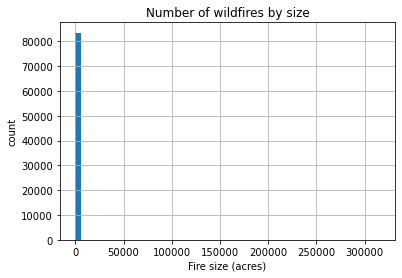

In [79]:
#plot a histogram
wildfires['FIRE_SIZE'].hist(bins=50)
plt.xlabel('Fire size (acres)')
plt.ylabel('count')
plt.title('Number of wildfires by size');

In [15]:
wildfires['FIRE_SIZE'].describe()

count     83709.000000
mean         84.251266
std        2515.436596
min           0.001000
25%           0.100000
50%           0.250000
75%           1.000000
max      315578.800000
Name: FIRE_SIZE, dtype: float64

In [24]:
np.percentile(wildfires['FIRE_SIZE'],[99])

array([400.])

Even with outliers (top 1%) removed, the distribution is still very skewed:

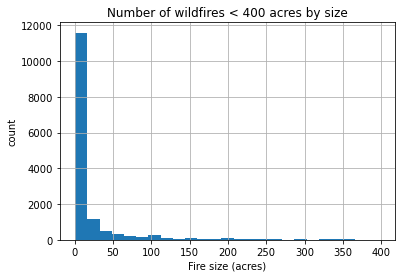

In [82]:
#histogram of wildfires <400 acres
#plot a histogram
wildfires[np.logical_and(wildfires.FIRE_SIZE < 400, wildfires.FIRE_SIZE > 1)]['FIRE_SIZE'].hist(bins=25)
plt.xlabel('Fire size (acres)')
plt.ylabel('count')
plt.title('Number of wildfires < 400 acres by size');

Trying various transformations:

In [47]:
#checking skew of target feature
skew_orig = wildfires['FIRE_SIZE'].skew()
skew_log = np.log(wildfires['FIRE_SIZE']).skew()
skew_sqrt = np.sqrt(wildfires['FIRE_SIZE']).skew()

std_orig = wildfires['FIRE_SIZE'].std()
std_log = np.log(wildfires['FIRE_SIZE']).std()
std_sqrt = np.sqrt(wildfires['FIRE_SIZE']).std()

print('Original: ', skew_orig, std_orig)
print('Log: ', skew_log, std_log)
print('Square Root: ', skew_sqrt, std_sqrt)

Original:  71.97260172604713 2515.436596487611
Log:  1.220090956163354 2.0533337443865736
Square Root:  25.11481660236228 9.02790439137289


In [48]:
skew_boxcox = pd.Series(stats.boxcox(wildfires['FIRE_SIZE'])[0]).skew()
std_boxcox = pd.Series(stats.boxcox(wildfires['FIRE_SIZE'])[0]).std()
print('Box Cox', skew_boxcox, std_boxcox)

Box Cox -0.044633776606421025 2.1571683244413173


In [44]:
wildfires['FIRE_SIZE_log'] = np.log(wildfires['FIRE_SIZE'])
wildfires['FIRE_SIZE_boxcox'] = pd.Series(stats.boxcox(wildfires['FIRE_SIZE'])[0])

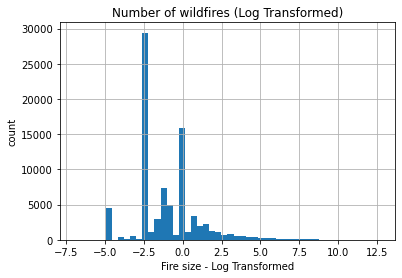

In [99]:
wildfires['FIRE_SIZE_log'].hist(bins=50)
plt.xlabel('Fire size - Log Transformed')
plt.ylabel('count')
plt.title('Number of wildfires (Log Transformed)');

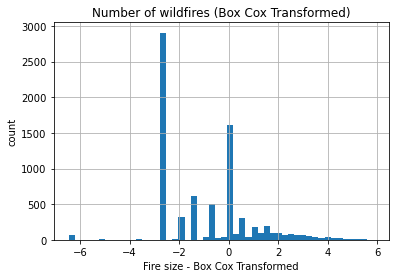

In [102]:
wildfires['FIRE_SIZE_boxcox'].hist(bins=50)
plt.xlabel('Fire size - Box Cox Transformed')
plt.ylabel('count')
plt.title('Number of wildfires (Box Cox Transformed)');

In all the transormations it appears that there are two peaks where a large proportion of the values are. What is this?

From the histogram below (zoomed in on wildfires <2 acres in size) we can see that the two peaks are at 1 acre and 0.1 acres. This suggests 

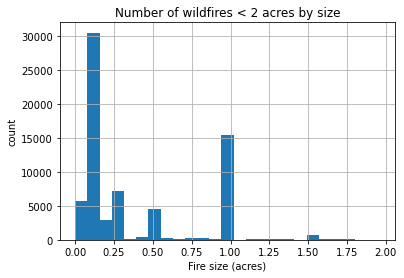

In [105]:
#histogram of wildfires <400 acres
#plot a histogram
wildfires[np.logical_and(wildfires.FIRE_SIZE < 2, wildfires.FIRE_SIZE > 0)]['FIRE_SIZE'].hist(bins=25)
plt.xlabel('Fire size (acres)')
plt.ylabel('count')
plt.title('Number of wildfires < 2 acres by size');

In [117]:
num_1acre = wildfires[wildfires.FIRE_SIZE ==1].shape[0]
print(num_1acre)

15371


In [118]:
num_01acre = wildfires[wildfires.FIRE_SIZE ==0.1].shape[0]
print(num_01acre)

29289


In [119]:
num_wildfires = wildfires.shape[0]
print(num_wildfires)

83709


In [120]:
(num_1acre + num_01acre) / num_wildfires

0.5335149147642428

Over 50% of the wildfires records have a wildfire size of 0.1 or 1 acres. A 0.1 acre wildfire is only 66 ft x 66 ft. We may want to consider removing these wildfires. Perhaps our model should only be predicting the size of wildfires once they become greater than 1 meter?

### EDA: Target Feature (Option 2)

Given issues discovered above with our intended target feature, perhaps we should explore another target feature option. We have a `FIRE_SIZE_CLASS` categorical feature which may be more useful than the continuous/exact size. Our model could predict the likelihood of a wildfire being in each size class, or we might predict the likleihood of a wildfire being above a certain size class.

From the original dataset documentation, the fire sizes classes are defined as follows:
* A=greater than 0 but less than or equal to 0.25 acres
* B=0.26-9.9 acres
* C=10.0-99.9 acres
* D=100-299 acres
* E=300 to 999 acres
* F=1000 to 4999 acres
* G=5000+ acres

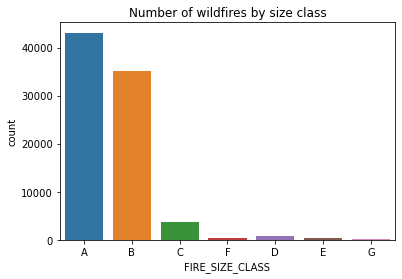

In [128]:
sns.countplot(x=wildfires['FIRE_SIZE_CLASS'])
plt.title('Number of wildfires by size class');

In [126]:
wildfires.groupby('FIRE_SIZE_CLASS').FIRE_SIZE_CLASS.count()

FIRE_SIZE_CLASS
A    43077
B    35031
C     3782
D      826
E      460
F      328
G      205
Name: FIRE_SIZE_CLASS, dtype: int64

The chart above suggests that using `FIRE_SIZE_CLASS` may work better. For now we'll stick with `FIRE_SIZE` but this can be revisited.

## EDA: Continuous Features

For each continuous feature: histogram, scatter plot, calculate correlation, and p value (sig or not)


In [113]:
#subset of continuous variables to keep that are anticipated to be explanatory variables
continuous_feats = ['DISCOVERY_DOY', 'elevation','slope','aspect',
                    'mean_monthly_ppt','dew_point','max_temp','wind_speed']

In [112]:
wildfires.info()

<class 'pandas.core.frame.DataFrame'>
Int64Index: 83709 entries, 1 to 1880465
Data columns (total 25 columns):
 #   Column                      Non-Null Count  Dtype         
---  ------                      --------------  -----         
 0   FIRE_NAME                   72471 non-null  object        
 1   SOURCE_REPORTING_UNIT_NAME  83709 non-null  object        
 2   FIRE_YEAR                   83709 non-null  int64         
 3   DISCOVERY_DT                83709 non-null  datetime64[ns]
 4   DISCOVERY_DOY               83709 non-null  int64         
 5   STAT_CAUSE_DESCR            83709 non-null  object        
 6   COUNTY_NAME                 83709 non-null  object        
 7   LATITUDE                    83709 non-null  float64       
 8   LONGITUDE                   83709 non-null  float64       
 9   geometry                    83709 non-null  object        
 10  FIRE_SIZE                   83709 non-null  float64       
 11  FIRE_SIZE_CLASS             83709 non-null  object  

In [49]:
def pearson_r(x, y):
    """Compute Pearson correlation coefficient between two arrays."""
    # Compute correlation matrix: corr_mat

    corr_mat = np.corrcoef(x,y)

    # Return entry [0,1]
    return corr_mat[0,1]

### Overview of Correlation

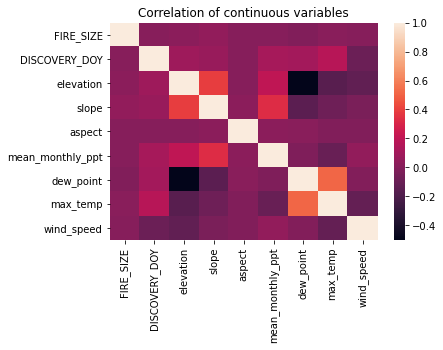

In [21]:
# Make a heatmap of the data
cont = ['FIRE_SIZE','DISCOVERY_DOY', 'elevation','slope','aspect',
                    'mean_monthly_ppt','dew_point','max_temp','wind_speed']
wildfire_cont = wildfires[cont]

#plt.subplots(figsize=(12,10))
sns.heatmap(wildfire_cont.corr())
plt.title('Correlation of continuous variables');

The heat map above is a bit worrying. None of the continuous variables appear to have much correlation at all with the target feature. Some of the explanatory variables have correlations - these are mostly expected interactions between topography and weather.

### DISCOVERY_DOY

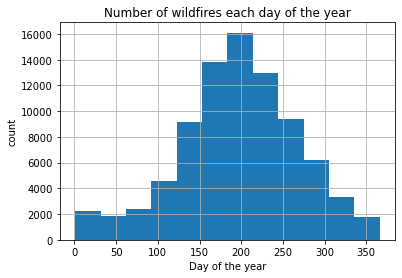

In [115]:
#plot a histogram
wildfires['DISCOVERY_DOY'].hist(bins=12)
plt.xlabel('Day of the year')
plt.ylabel('count')
plt.title('Number of wildfires each day of the year');

The histogram above shows that the wildfires are normally distributed across the year, with the most fires occuring in the summer months. The median is 197 (corresponding to mind July). The IQR is 155-244, meaning that 50% of the fires have occured between early June and late August.

In [116]:
#summary statistics
wildfires['DISCOVERY_DOY'].describe()

count    83709.000000
mean       196.539058
std         71.019771
min          1.000000
25%        155.000000
50%        197.000000
75%        244.000000
max        366.000000
Name: DISCOVERY_DOY, dtype: float64

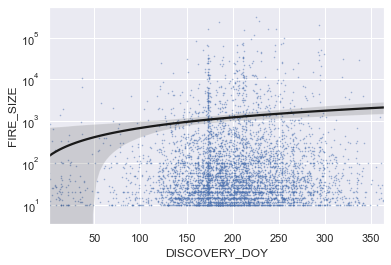

In [270]:
#scatter plot against target feature (with regression line)
sns.regplot(x = 'DISCOVERY_DOY', y = 'FIRE_SIZE', data=wildfires_large, scatter_kws={'s':0.3, 'alpha':0.5},
            line_kws={'color':'k'}).set_yscale('log');

In [133]:
#calculate pearson correlation
r, p = stats.pearsonr(wildfires.FIRE_SIZE, wildfires.DISCOVERY_DOY)

print('R: ',round(r,4))
print('P: ',round(p,4))

R:  0.0083
P:  0.0157


`WILDFIRE_SIZE` and `DISCOVERY_DOY` do not have strong linear correlation - the largest wilfires occur in the middle of the year. This suggests that using `DISOVERY_MONTH` as a categorical variable will produce better results.

### ELEVATION

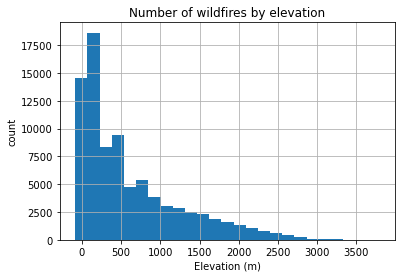

In [98]:
#plot a histogram
wildfires['elevation'].hist(bins=25)
plt.xlabel('Elevation (m)')
plt.ylabel('count')
plt.title('Number of wildfires by elevation');

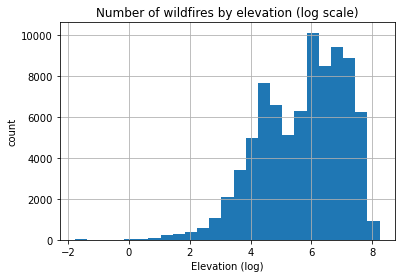

In [145]:
elevation_log = wildfires[['FIRE_SIZE','elevation']].copy()
elevation_log.loc[:,'elevation_noZ'] = elevation_log.elevation
elevation_log.elevation_noZ.replace(to_replace=0, value=0.2, inplace=True)
elevation_log['elevation_log'] = np.log(elevation_log.elevation_noZ)

elevation_log['elevation_log'].hist(bins=25)
plt.xlabel('Elevation (log)')
plt.ylabel('count')
plt.title('Number of wildfires by elevation (log scale)');

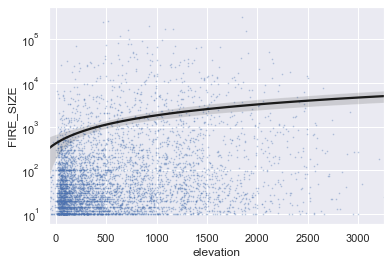

In [272]:
#scatter plot against target feature (with regression line)
sns.regplot(x = 'elevation', y = 'FIRE_SIZE', data=wildfires_large, scatter_kws={'s':0.5, 'alpha':0.3},
            line_kws={'color':'k'}).set_yscale('log');

Distribution of elevation is right tailed. This is surprising since conventional wisdom is that most wildfires in California occur in the mountainous areas.

This could be because high elevation areas simply cover less of the state. It also is expected that while wildfires do occur in mountainous areas, they won't occur often in very high elevation areas because these areas usually do not have a lot of vegetation. Similarly, areas below sea level are deserts and also shouldn't have too may fires (hence the dip at 0 in the histogram).

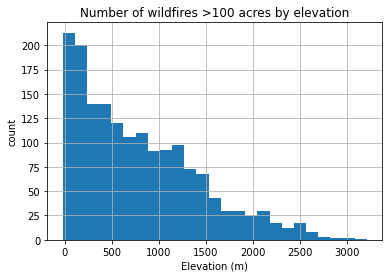

In [67]:
#plot a histogram
wildfires[wildfires['FIRE_SIZE']>100]['elevation'].hist(bins=25)
plt.xlabel('Elevation (m)')
plt.ylabel('count')
plt.title('Number of wildfires >100 acres by elevation');

When we filter for only large wildfires (>100 acres) we see that the distribution is still right tailed, but not as extreme. 

In [148]:
#summary statistics
wildfires['elevation'].describe()

count    83709.000000
mean       607.698308
std        641.072349
min        -83.107810
25%         99.538370
50%        387.928560
75%        913.167100
max       3795.679200
Name: elevation, dtype: float64

In [64]:
wildfires['elevation'].skew()

1.3219731620493405

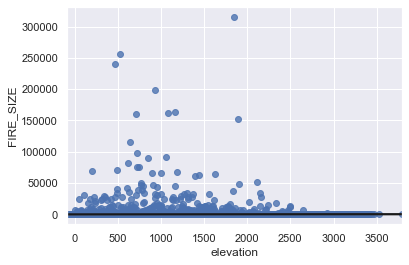

In [274]:
#scatter plot against target feature (with regression line)
sns.regplot(x = 'elevation', y = 'FIRE_SIZE', data=wildfires, line_kws={'color':'k'});

In [277]:
#calculate pearson correlation
r, p = stats.pearsonr(wildfires_large.FIRE_SIZE_log, wildfires_large.elevation)

print('R: ',round(r,8))
print('P: ',round(p,8))

R:  0.24444642
P:  0.0


### Slope

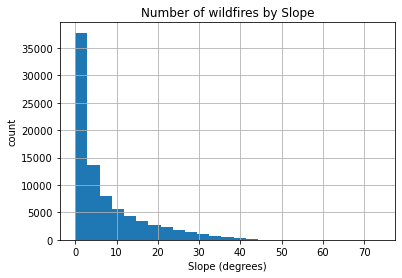

In [71]:
#plot a histogram
wildfires['slope'].hist(bins=25)
plt.xlabel('Slope (degrees)')
plt.ylabel('count')
plt.title('Number of wildfires by Slope');

Again, the distribution is right tailed. This is not surprising as the vast majority of land in California is flat (ie the central valley, deserts), and even in mountainous areas a slope of ~10 degrees is quite steep.

We may need to convert this into a categorical variable (ie, flat, low slope, medium slope, steep slope).

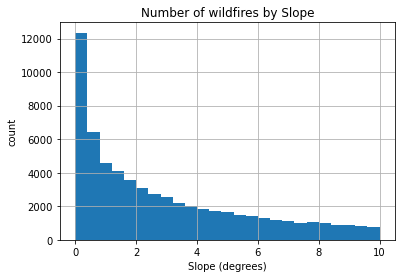

In [72]:
#plot a histogram
wildfires[wildfires['slope']<10]['slope'].hist(bins=25)
plt.xlabel('Slope (degrees)')
plt.ylabel('count')
plt.title('Number of wildfires by Slope');

In [70]:
#summary statistics
wildfires['slope'].describe()

count    83709.000000
mean         7.242274
std          8.672249
min          0.000000
25%          0.979244
50%          3.642325
75%         10.517176
max         73.758484
Name: slope, dtype: float64

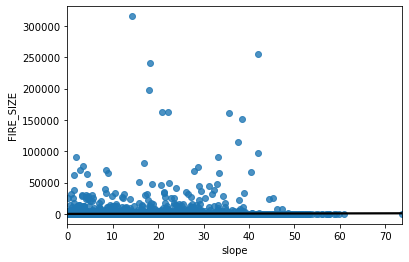

In [152]:
#scatter plot against target feature (with regression line)
sns.regplot(x = 'slope', y = 'FIRE_SIZE', data=wildfires, line_kws={'color':'k'});

In [151]:
#calculate pearson correlation
r, p = stats.pearsonr(wildfires.FIRE_SIZE, wildfires.slope)

print('R: ',r)
print('P: ',p)

R:  0.04512322044489778
P:  5.447058309109541e-39


### Aspect

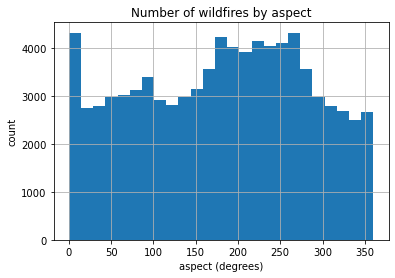

In [78]:
#plot a histogram
wildfires['aspect'].hist(bins=25)
plt.xlabel('aspect (degrees)')
plt.ylabel('count')
plt.title('Number of wildfires by aspect');

We see a peak ~175-275 degrees. This corresponds to S, SW, and W facing slopes. This is likely because these slopes tend to get more sun and therefore have drier conditions. 

We see another peak at 0 degrees. This is because the aspect calculation assigns a 0 to flat areas. So if we were to plot this same histogram for all wildfires with aspect != 0 we would see this bar disappear.

In [153]:
#summary statistics
wildfires['aspect'].describe()

count    83709.000000
mean       179.723849
std        100.230394
min         -0.000000
25%         93.774910
50%        186.657330
75%        261.261300
max        359.999150
Name: aspect, dtype: float64

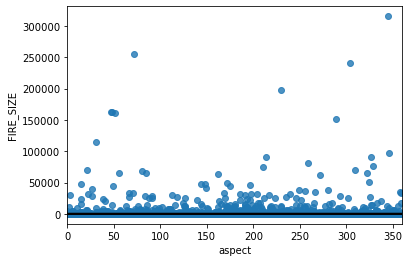

In [154]:
#scatter plot against target feature (with regression line)
sns.regplot(x = 'aspect', y = 'FIRE_SIZE', data=wildfires, line_kws={'color':'k'});

In [155]:
#calculate pearson correlation
r, p = stats.pearsonr(wildfires.FIRE_SIZE, wildfires.aspect)

print('R: ',round(r,8))
print('P: ',round(p,8))

R:  0.00182572
P:  0.59734733


### Precipitation

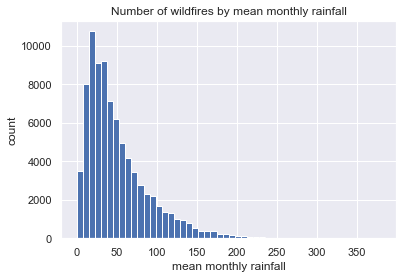

In [298]:
#plot a histogram
wildfires['mean_monthly_ppt'].hist(bins=50)
plt.xlabel('mean monthly rainfall')
plt.ylabel('count')
plt.title('Number of wildfires by mean monthly rainfall');

In [161]:
#summary statistics
wildfires['mean_monthly_ppt'].describe()

count    83709.000000
mean        50.650968
std         39.724616
min          0.000250
25%         21.806417
50%         39.135750
75%         67.773750
max        379.856842
Name: mean_monthly_ppt, dtype: float64

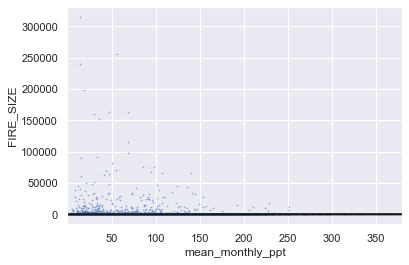

In [297]:
#scatter plot against target feature (with regression line)
sns.regplot(x = 'mean_monthly_ppt', y = 'FIRE_SIZE', data=wildfires, line_kws={'color':'k'}, scatter_kws={'s':0.5, 'alpha':0.5});

In [296]:
#calculate pearson correlation
r, p = stats.pearsonr(wildfires.FIRE_SIZE, wildfires.mean_monthly_ppt)

print('R: ',round(r,8))
print('P: ',round(p,8))

R:  0.00463316
P:  0.18009053


### Humidity

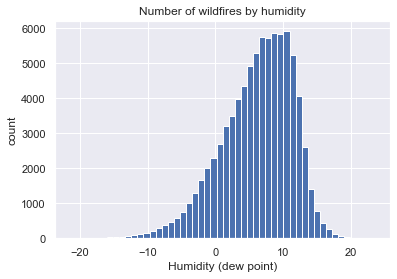

In [295]:
#plot a histogram
wildfires['dew_point'].hist(bins=50)
plt.xlabel('Humidity (dew point)')
plt.ylabel('count')
plt.title('Number of wildfires by humidity');

In [294]:
#summary statistics
wildfires['dew_point'].describe()

count    83709.000000
mean         6.096611
std          5.278193
min        -21.426287
25%          2.848571
50%          6.819286
75%         10.059714
max         23.549286
Name: dew_point, dtype: float64

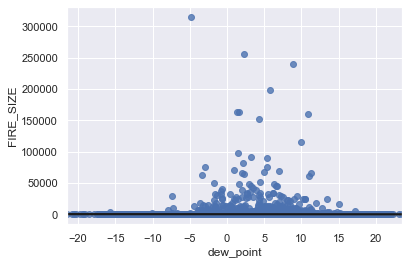

In [293]:
#scatter plot against target feature (with regression line)
sns.regplot(x = 'dew_point', y = 'FIRE_SIZE', data=wildfires, line_kws={'color':'k'});

In [292]:
#calculate pearson correlation
r, p = stats.pearsonr(wildfires.FIRE_SIZE, wildfires.dew_point)

print('R: ',round(r,8))
print('P: ',round(p,8))

R:  -0.01344129
P:  0.00010065


### Temperature

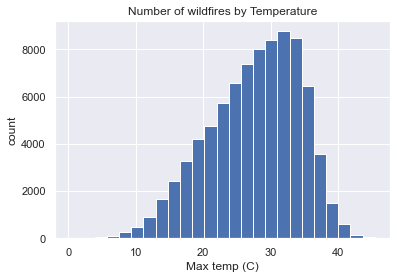

In [291]:
#plot a histogram
wildfires['max_temp'].hist(bins=25)
plt.xlabel('Max temp (C)')
plt.ylabel('count')
plt.title('Number of wildfires by Temperature');

In [178]:
#summary statistics
wildfires['max_temp'].describe()

count    83709.000000
mean        27.497324
std          6.754950
min          0.305143
25%         22.844999
50%         28.317142
75%         32.750427
max         45.421288
Name: max_temp, dtype: float64

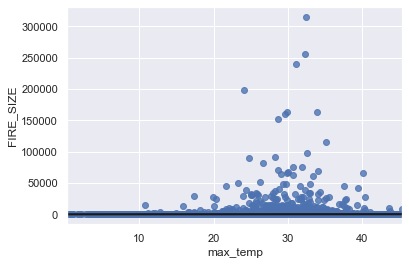

In [290]:
#scatter plot against target feature (with regression line)
sns.regplot(x = 'max_temp', y = 'FIRE_SIZE', data=wildfires, line_kws={'color':'k'});

In [180]:
#calculate pearson correlation
r, p = stats.pearsonr(wildfires.FIRE_SIZE, wildfires.max_temp)

print('R: ',round(r,8))
print('P: ',round(p,8))

R:  0.01273783
P:  0.00022828


### Wind Speed

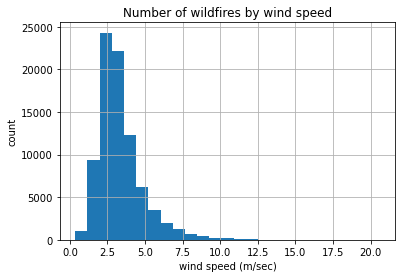

In [181]:
#plot a histogram
wildfires['wind_speed'].hist(bins=25)
plt.xlabel('wind speed (m/sec)')
plt.ylabel('count')
plt.title('Number of wildfires by wind speed');

In [182]:
#summary statistics
wildfires['wind_speed'].describe()

count    83709.000000
mean         3.345165
std          1.510318
min          0.359634
25%          2.371171
50%          3.011967
75%          3.929377
max         20.599342
Name: wind_speed, dtype: float64

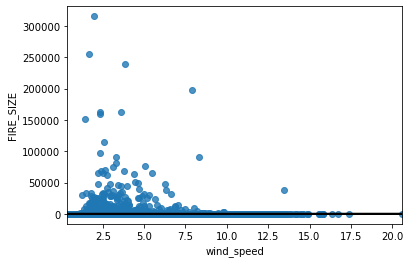

In [183]:
#scatter plot against target feature (with regression line)
sns.regplot(x = 'wind_speed', y = 'FIRE_SIZE', data=wildfires, line_kws={'color':'k'});

In [184]:
#calculate pearson correlation
r, p = stats.pearsonr(wildfires.FIRE_SIZE, wildfires.wind_speed)

print('R: ',round(r,8))
print('P: ',round(p,8))

R:  0.00143744
P:  0.67749736


## EDA: Categorical Features

For each categorical feature: count plot, box blot (vs target feature), ANOVA/log regression

In [185]:
wildfires.columns

Index(['FIRE_NAME', 'SOURCE_REPORTING_UNIT_NAME', 'FIRE_YEAR', 'DISCOVERY_DT',
       'DISCOVERY_DOY', 'STAT_CAUSE_DESCR', 'COUNTY_NAME', 'LATITUDE',
       'LONGITUDE', 'geometry', 'FIRE_SIZE', 'FIRE_SIZE_CLASS', 'elevation',
       'slope', 'aspect', 'mean_monthly_ppt', 'dew_point', 'max_temp',
       'wind_speed', 'WHRNAME', 'WHR10NAME', 'US_L3NAME', 'NA_L2NAME',
       'DISCOVERY_MONTH', 'aspect_cat', 'FIRE_SIZE_log', 'FIRE_SIZE_boxcox',
       'elevation_log'],
      dtype='object')

In [186]:
categorical_features = ['DISCOVERY_MONTH', 'WHRNAME', 'WHR10NAME', 'US_L3NAME', 'NA_L2NAME', 'aspect_cat']

In [234]:
wildfires_large = wildfires[np.logical_and(wildfires.FIRE_SIZE_CLASS != 'A', wildfires.FIRE_SIZE_CLASS != 'B')]
wildfires_large.shape

(5601, 28)

### Discovery Month

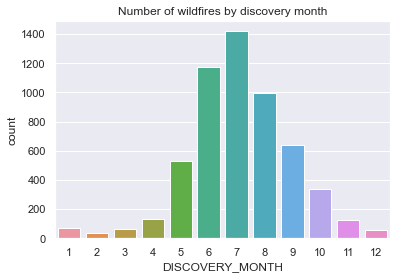

In [235]:
#count plot
sns.countplot(x=wildfires_large['DISCOVERY_MONTH'])
plt.title('Number of wildfires by discovery month');

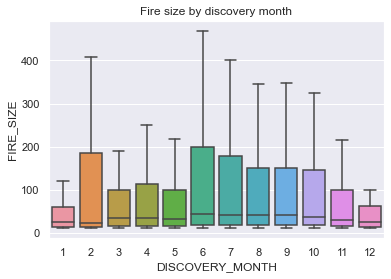

In [236]:
# box plot
sns.boxplot(x='DISCOVERY_MONTH', y='FIRE_SIZE', data=wildfires_large, sym='')
plt.title('Fire size by discovery month');

In [263]:
wildfires_large.groupby('DISCOVERY_MONTH')['FIRE_SIZE'].describe()

,count,mean,std,min,25%,50%,75%,max
DISCOVERY_MONTH,,,,,,,,
1,73.0,119.965753,308.825657,10.0,13.500,25.00,60.00,1980.0
2,39.0,609.598462,1985.772417,10.0,12.200,22.94,184.50,10584.0
3,67.0,201.567164,571.871818,10.0,15.000,35.00,100.00,4100.0
4,133.0,192.560977,536.734628,10.0,15.000,35.00,112.00,4000.0
5,533.0,393.976567,2045.813077,10.0,15.000,32.30,100.10,30274.0
6,1174.0,1212.726056,7020.558198,10.0,18.850,44.00,200.00,162818.0
7,1419.0,1458.037463,9358.199281,10.0,17.000,41.00,177.15,240207.0
8,997.0,1623.093149,14907.559885,10.0,18.000,40.00,150.00,315578.8
9,641.0,1357.507129,9427.213199,10.0,17.000,40.00,150.00,162702.0


In [266]:
f, p = stats.f_oneway(wildfires_large['FIRE_SIZE'][wildfires_large['DISCOVERY_MONTH'] == 1],
                      wildfires_large['FIRE_SIZE'][wildfires_large['DISCOVERY_MONTH'] == 2],
                      wildfires_large['FIRE_SIZE'][wildfires_large['DISCOVERY_MONTH'] == 3],
                      wildfires_large['FIRE_SIZE'][wildfires_large['DISCOVERY_MONTH'] == 4],
                      wildfires_large['FIRE_SIZE'][wildfires_large['DISCOVERY_MONTH'] == 5],
                      wildfires_large['FIRE_SIZE'][wildfires_large['DISCOVERY_MONTH'] == 6],
                      wildfires_large['FIRE_SIZE'][wildfires_large['DISCOVERY_MONTH'] == 7],
                      wildfires_large['FIRE_SIZE'][wildfires_large['DISCOVERY_MONTH'] == 8],
                      wildfires_large['FIRE_SIZE'][wildfires_large['DISCOVERY_MONTH'] == 9],
                      wildfires_large['FIRE_SIZE'][wildfires_large['DISCOVERY_MONTH'] == 10],
                      wildfires_large['FIRE_SIZE'][wildfires_large['DISCOVERY_MONTH'] == 11],
                      wildfires_large['FIRE_SIZE'][wildfires_large['DISCOVERY_MONTH'] == 12])
print(f,p)

1.1111756902207242 0.3473787126354315


### Vegetation Type

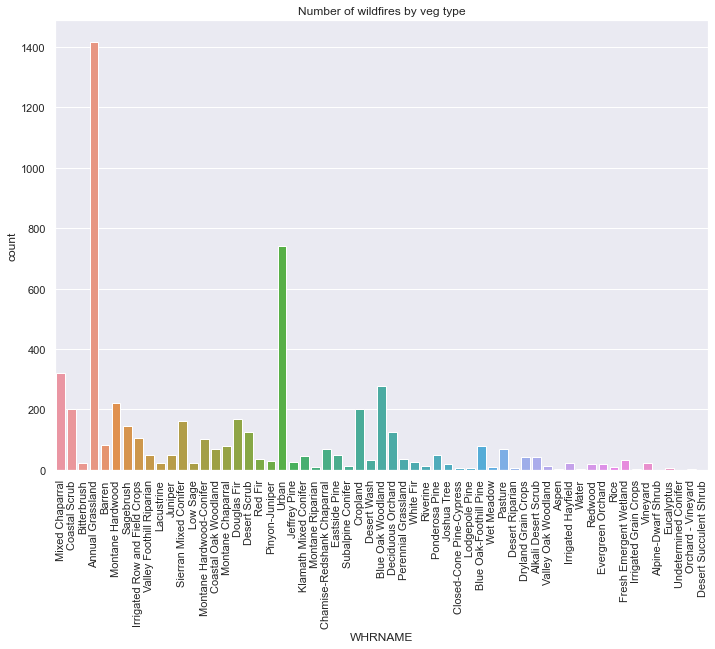

In [239]:
sns.countplot(x=wildfires_large['WHRNAME'])
sns.set(rc={'figure.figsize':(11.7,8.27)})
plt.xticks(rotation=90)
plt.title('Number of wildfires by veg type');

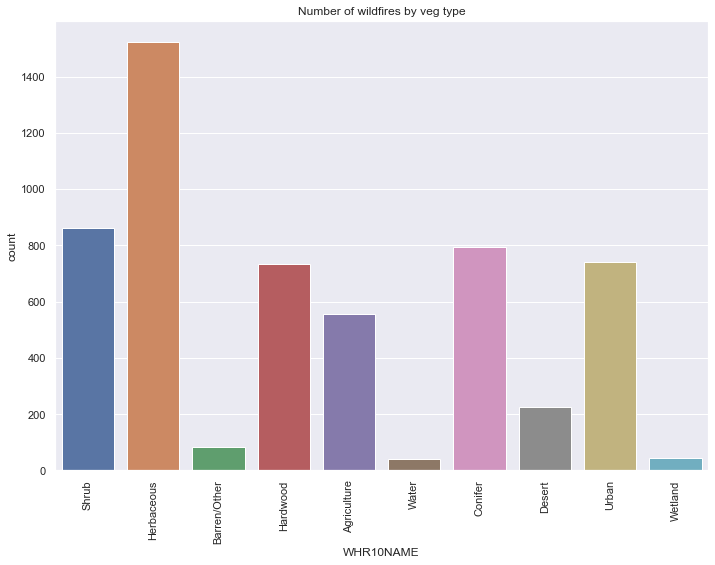

In [240]:
sns.countplot(x=wildfires_large['WHR10NAME'])
sns.set(rc={'figure.figsize':(6,4)})
plt.xticks(rotation=90)
plt.title('Number of wildfires by veg type');

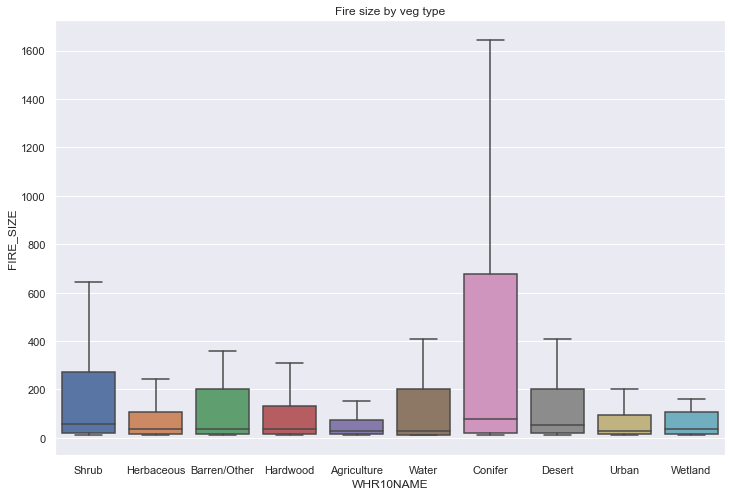

In [245]:
sns.boxplot(x='WHR10NAME', y='FIRE_SIZE', data=wildfires_large, sym='')
sns.set(rc={'figure.figsize':(12,8)})
plt.title('Fire size by veg type');

In [247]:
wildfires_large.groupby('WHR10NAME')['FIRE_SIZE'].mean()

WHR10NAME
Agriculture      248.835827
Barren/Other    1191.556707
Conifer         2688.125101
Desert          1034.790311
Hardwood        1382.306139
Herbaceous       502.578627
Shrub           2643.288852
Urban            402.080997
Water            452.992500
Wetland          254.367442
Name: FIRE_SIZE, dtype: float64

In [299]:
#checking std of each group - ANOVA test requires similar distributions
wildfires_large.groupby('WHR10NAME')['FIRE_SIZE'].std()

WHR10NAME
Agriculture      1859.506591
Barren/Other     5522.082450
Conifer         10584.606618
Desert           5564.081934
Hardwood         8218.875825
Herbaceous       6993.271324
Shrub           18168.847789
Urban            3203.806947
Water            1380.359802
Wetland           998.324246
Name: FIRE_SIZE, dtype: float64

In [268]:
#One-sided ANOVA test
f, p = stats.f_oneway(wildfires_large['FIRE_SIZE'][wildfires_large['WHR10NAME'] == 'Agriculture'],
                      wildfires_large['FIRE_SIZE'][wildfires_large['WHR10NAME'] == 'Barren/Other'],
                      wildfires_large['FIRE_SIZE'][wildfires_large['WHR10NAME'] == 'Conifer'],
                      wildfires_large['FIRE_SIZE'][wildfires_large['WHR10NAME'] == 'Desert'],
                      wildfires_large['FIRE_SIZE'][wildfires_large['WHR10NAME'] == 'Hardwood'],
                      wildfires_large['FIRE_SIZE'][wildfires_large['WHR10NAME'] == 'Herbaceous'],
                      wildfires_large['FIRE_SIZE'][wildfires_large['WHR10NAME'] == 'Shrub'],
                      wildfires_large['FIRE_SIZE'][wildfires_large['WHR10NAME'] == 'Urban'],
                      wildfires_large['FIRE_SIZE'][wildfires_large['WHR10NAME'] == 'Water'],
                      wildfires_large['FIRE_SIZE'][wildfires_large['WHR10NAME'] == 'Wetland'])
print(f,p)                   

6.441551436402214 3.6919445509946725e-09


### EPA EcoRegion

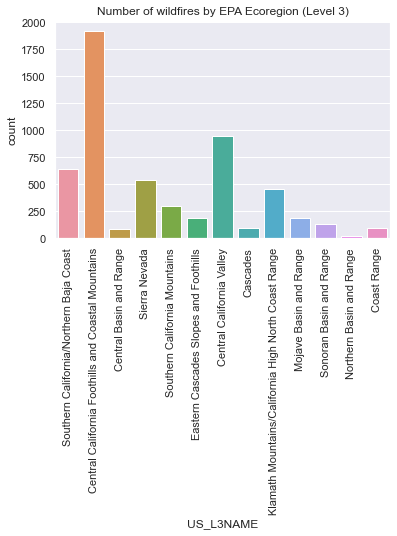

In [251]:
sns.countplot(x=wildfires_large['US_L3NAME'])
sns.set(rc={'figure.figsize':(6,4)})
plt.xticks(rotation=90)
plt.title('Number of wildfires by EPA Ecoregion (Level 3)');

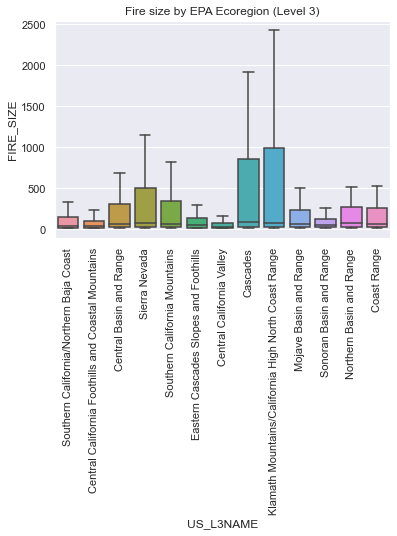

In [252]:
sns.boxplot(x='US_L3NAME', y='FIRE_SIZE', data=wildfires_large, sym='')
sns.set(rc={'figure.figsize':(6,4)})
plt.xticks(rotation=90)
plt.title('Fire size by EPA Ecoregion (Level 3)');

In [301]:
wildfires_large['US_L3NAME'].unique()

array(['Southern California/Northern Baja Coast',
       'Central California Foothills and Coastal Mountains',
       'Central Basin and Range', 'Sierra Nevada',
       'Southern California Mountains',
       'Eastern Cascades Slopes and Foothills',
       'Central California Valley', 'Cascades',
       'Klamath Mountains/California High North Coast Range',
       'Mojave Basin and Range', 'Sonoran Basin and Range',
       'Northern Basin and Range', 'Coast Range'], dtype=object)

In [302]:
#One-sided ANOVA test
f, p = stats.f_oneway(wildfires_large['FIRE_SIZE'][wildfires_large['US_L3NAME'] == 'Southern California/Northern Baja Coast'],
                      wildfires_large['FIRE_SIZE'][wildfires_large['US_L3NAME'] == 'Central California Foothills and Coastal Mountains'],
                      wildfires_large['FIRE_SIZE'][wildfires_large['US_L3NAME'] == 'Central Basin and Range'],
                      wildfires_large['FIRE_SIZE'][wildfires_large['US_L3NAME'] == 'Southern California Mountains'],
                      wildfires_large['FIRE_SIZE'][wildfires_large['US_L3NAME'] == 'Sierra Nevada'],
                      wildfires_large['FIRE_SIZE'][wildfires_large['US_L3NAME'] == 'Eastern Cascades Slopes and Foothills'],
                      wildfires_large['FIRE_SIZE'][wildfires_large['US_L3NAME'] == 'Central California Valley'],
                      wildfires_large['FIRE_SIZE'][wildfires_large['US_L3NAME'] == 'Cascades'],
                      wildfires_large['FIRE_SIZE'][wildfires_large['US_L3NAME'] == 'Klamath Mountains/California High North Coast Range'],
                      wildfires_large['FIRE_SIZE'][wildfires_large['US_L3NAME'] == 'Mojave Basin and Range'],
                     wildfires_large['FIRE_SIZE'][wildfires_large['US_L3NAME'] == 'Mojave Basin and Range'],
                     wildfires_large['FIRE_SIZE'][wildfires_large['US_L3NAME'] == 'Sonoran Basin and Range'],
                     wildfires_large['FIRE_SIZE'][wildfires_large['US_L3NAME'] == 'Northern Basin and Range'],
                     wildfires_large['FIRE_SIZE'][wildfires_large['US_L3NAME'] == 'Coast Range'])
print(f,p)  

8.644184244512255 9.926466286488874e-18


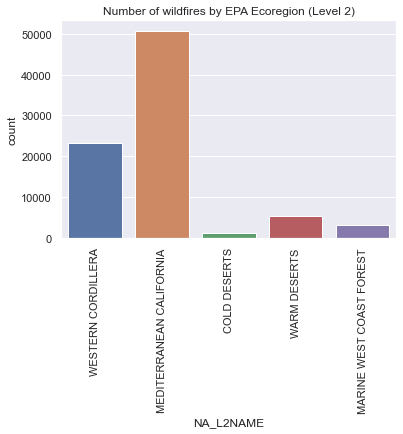

In [221]:
sns.countplot(x=wildfires['NA_L2NAME'])
plt.xticks(rotation=90)
plt.title('Number of wildfires by EPA Ecoregion (Level 2)');

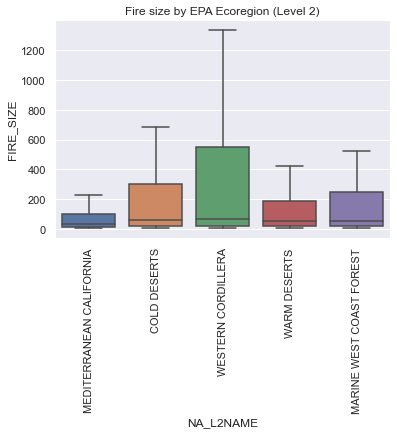

In [253]:
sns.boxplot(x='NA_L2NAME', y='FIRE_SIZE', data=wildfires_large, sym='')
plt.xticks(rotation=90)
plt.title('Fire size by EPA Ecoregion (Level 2)');

In [303]:
wildfires_large['NA_L2NAME'].unique()

array(['MEDITERRANEAN CALIFORNIA', 'COLD DESERTS', 'WESTERN CORDILLERA',
       'WARM DESERTS', 'MARINE WEST COAST FOREST'], dtype=object)

In [305]:
#One-sided ANOVA test
f, p = stats.f_oneway(wildfires_large['FIRE_SIZE'][wildfires_large['NA_L2NAME'] == 'MEDITERRANEAN CALIFORNIA'],
                      wildfires_large['FIRE_SIZE'][wildfires_large['NA_L2NAME'] == 'COLD DESERTS'],
                      wildfires_large['FIRE_SIZE'][wildfires_large['NA_L2NAME'] == 'WESTERN CORDILLERA'],
                      wildfires_large['FIRE_SIZE'][wildfires_large['NA_L2NAME'] == 'WARM DESERTS'],
                      wildfires_large['FIRE_SIZE'][wildfires_large['NA_L2NAME'] == 'MARINE WEST COAST FOREST'])

print (f,p)

8.175643401462779 1.4333189998880705e-06


### Aspect Category
(ie cardinal direction)

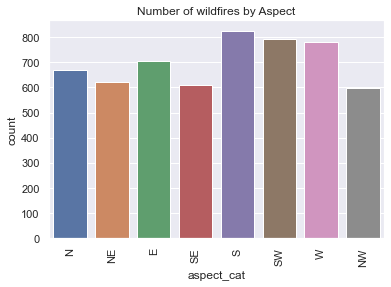

In [254]:
order = ['N','NE','E','SE','S','SW','W','NW']

sns.countplot(x=wildfires_large['aspect_cat'], order=order)
plt.xticks(rotation=90)
plt.title('Number of wildfires by Aspect');


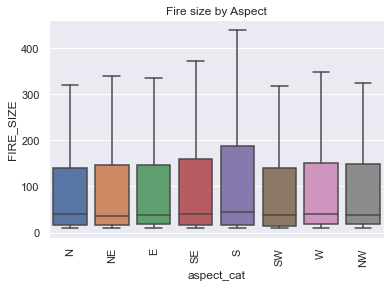

In [256]:
sns.boxplot(x='aspect_cat', y='FIRE_SIZE', data=wildfires_large, order=order, sym='')
plt.xticks(rotation=90)
plt.title('Fire size by Aspect');

In [306]:
#One-sided ANOVA test
f, p = stats.f_oneway(wildfires_large['FIRE_SIZE'][wildfires_large['aspect_cat'] == 'N'],
                     wildfires_large['FIRE_SIZE'][wildfires_large['aspect_cat'] == 'NE'],
                     wildfires_large['FIRE_SIZE'][wildfires_large['aspect_cat'] == 'E'],
                     wildfires_large['FIRE_SIZE'][wildfires_large['aspect_cat'] == 'SE'],
                     wildfires_large['FIRE_SIZE'][wildfires_large['aspect_cat'] == 'S'],
                     wildfires_large['FIRE_SIZE'][wildfires_large['aspect_cat'] == 'SW'],
                     wildfires_large['FIRE_SIZE'][wildfires_large['aspect_cat'] == 'W'],
                     wildfires_large['FIRE_SIZE'][wildfires_large['aspect_cat'] == 'NW'],
                     )

print (f,p)

0.6557614614060898 0.709794153727699


# Conclusions

Observations
* Large number of very small wildfires is dominating trends and statistics. This is concerning because we care much more about predicting large wildfires.
* Continous variables do not show strong correlation with `FIRE_SIZE`. They also do not perform well with linear regression. This may because the relationship with `FIRE_SIZE` shouldn't be linear. For example, medium wind speeds may increase fire size but very high wind speeds may blow fires out.
* Categorical variables appear to have more of a pattern but the ANOVA tests are inconclusive. Note that I used a filtered version of the wildfire dataset for EDA on categorical variables (>10 acres).

Options
* Use `FIRE_SIZE_CLASS` as target variable - this would help address the skew of the data, and may even be more useful for prediction
* Filter out wildfires that are Class A or B (ie less than 10 acres). This would substantially reduce the number of data points from ~83,000 to 5,601. It would also change the utility of the model - it would now be only able to predict the size of wildfires once they are greater than 10 acres.
* Both of the above options could be used together - the model would then be predicting: once a wildfire exceeds 10 acres, what is the probablity that it will be size C, D, E, F, G?
* Another simpler option: once a wildfire exceeds 10 acres, what is the probablity that it will become a very large wildfire?

Questions
* Both pearson correlation and ANOVA tests require inputs to be normally distributed - since `FIRE_SIZE` is definitely not normally distributed doesn't this invalidate the results of all my tests?
* Is there a way to fit a curve rather than a straight line to the data? Perhaps this would work better for continuous variables
* I'm unsure about how to interpret the ANOVA test results.
* Given that most of the tests are inconclusive and the distributions are not normal, is there anything I can conclusdfe from this exercise? Are there any more EDA steps I should take? For example, replacing `FIRE_SIZE_CLASS` as the target variable?